In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
%cd drive/My\ Drive/

/content/drive/My Drive


In [0]:
%cd 'k9'

/content/drive/My Drive/k9


In [0]:
#!ls

In [0]:
!unzip 'valid.zip'

In [0]:
!unzip 'train.zip'

In [0]:
!unzip 'test.zip'

In [0]:
!pip3 install torch===1.2.0 torchvision===0.4.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install typeguard

In [0]:
#Imports
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy as sp
from functools import partial
from sklearn import metrics
from collections import Counter
from fastai.callbacks import *
import PIL
import cv2
import sklearn
import skimage
bs = 64

In [0]:
%cd ..

/content/drive/My Drive


In [0]:
#images_path
path_images = Path('k9')

In [0]:
#data path and init
data = ImageDataBunch.from_folder(path=path_images, train='train', valid='valid', bs=bs, classes=['TT','others','garbage']) 
data.normalize()

ImageDataBunch;

Train: LabelList (18786 items)
x: ImageList
Image (3, 31, 279),Image (3, 31, 279),Image (3, 31, 279),Image (3, 31, 279),Image (3, 31, 279)
y: CategoryList
garbage,garbage,garbage,garbage,garbage
Path: k9;

Valid: LabelList (6119 items)
x: ImageList
Image (3, 31, 279),Image (3, 31, 279),Image (3, 31, 279),Image (3, 31, 279),Image (3, 31, 279)
y: CategoryList
others,others,others,others,others
Path: k9;

Test: None

In [0]:
data.classes

['TT', 'others', 'garbage']

In [0]:
learn = cnn_learner(data, models.resnet152, metrics=error_rate)
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.57E-04
Min loss divided by 10: 1.51E-02


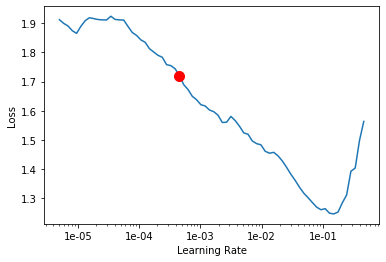

In [0]:
# learn.freeze()
learn.lr_find(start_lr=1e-6, end_lr=1e1, wd=5e-3)
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,time
0,0.226178,0.164080,0.063899,01:35


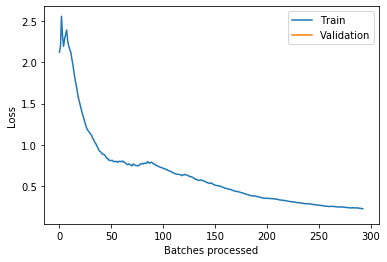

In [0]:
learn.fit_one_cycle(1, max_lr=slice(9e-4, 8e-2))
#learn.save('-stage1')
learn.recorder.plot_losses()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.58E-07


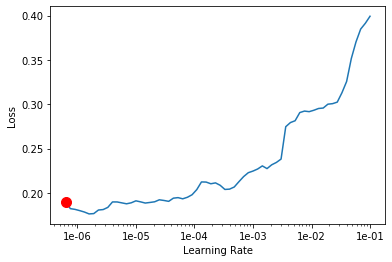

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(1, max_lr=slice(1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.187966,0.160636,0.063572,01:48


epoch,train_loss,valid_loss,error_rate,time
0,0.182252,0.159143,0.062755,01:48
1,0.178191,0.157348,0.062429,01:49
2,0.172885,0.156662,0.062102,01:49
3,0.174949,0.155651,0.062592,01:50
4,0.167028,0.155494,0.061611,01:49


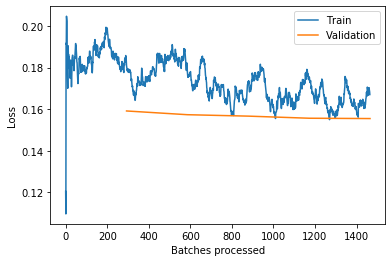

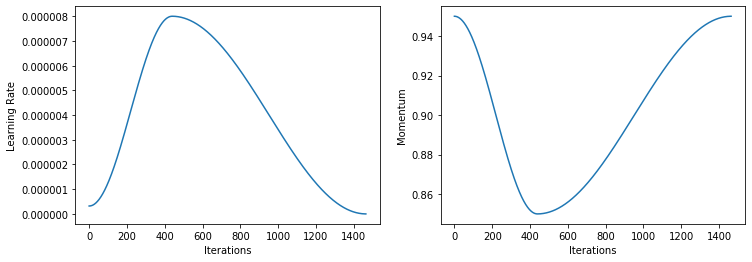

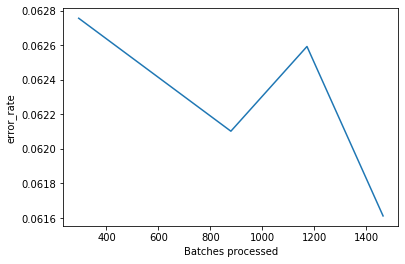

In [0]:
learn.fit_one_cycle(5, max_lr=slice(8e-6))
learn.save('bcells-r152-ndata-k9')
learn.recorder.plot_losses()
# # schedule of the lr (left) and momentum (right) that the 1cycle policy uses
learn.recorder.plot_lr(show_moms=True)
learn.recorder.plot_metrics()

In [0]:
learn.load('bcells-r152-ndata-k9')
interp = ClassificationInterpretation.from_learner(learn)

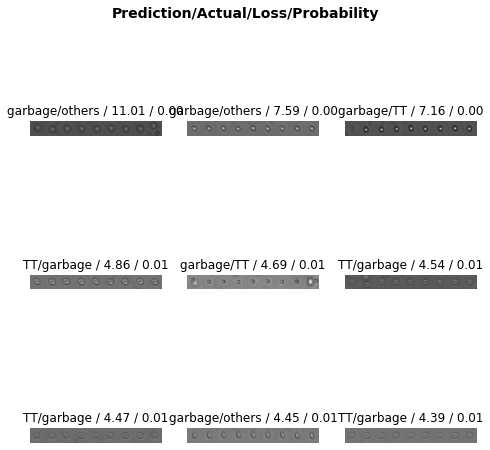

In [0]:
interp.plot_top_losses(9, figsize=(8,8))

In [0]:
losses, indexes = interp.top_losses(20)

top_loss_paths = data.valid_ds.x.items[indexes]

print(top_loss_paths)

[PosixPath('k9/valid/others/BM1024_10s01_141.jpg') PosixPath('k9/valid/others/BG1003_10s02_114.jpg')
 PosixPath('k9/valid/TT/BK1024_10s01_132.jpg') PosixPath('k9/valid/garbage/BK1010_10s02_1240.jpg')
 PosixPath('k9/valid/TT/BG1017_10s02_88.jpg') PosixPath('k9/valid/garbage/BM1024_10s02_887.jpg')
 PosixPath('k9/valid/garbage/BG1003_10s02_1764.jpg') PosixPath('k9/valid/others/BK1003_10s05_193.jpg')
 PosixPath('k9/valid/garbage/BK1010_10s02_2314.jpg') PosixPath('k9/valid/garbage/BG1022_10s02_2503.jpg')
 PosixPath('k9/valid/garbage/BK0926_10s01_4068.jpg') PosixPath('k9/valid/others/BK1003_10s03_152.jpg')
 PosixPath('k9/valid/others/BG1022_10s01_207.jpg') PosixPath('k9/valid/others/BK1010_10s01_252.jpg')
 PosixPath('k9/valid/garbage/BM1024_10s01_1762.jpg') PosixPath('k9/valid/others/BK1003_10s01_205.jpg')
 PosixPath('k9/valid/others/LJ0926_10s01_249.jpg') PosixPath('k9/valid/others/BK1010_10s01_248.jpg')
 PosixPath('k9/valid/garbage/BK0926_10s01_7053.jpg') PosixPath('k9/valid/garbage/BK1017

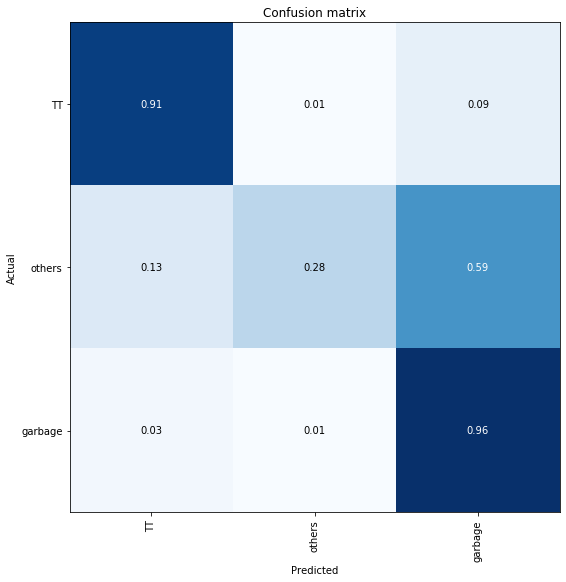

In [0]:
interp.plot_confusion_matrix(normalize=True, figsize=(8,8))

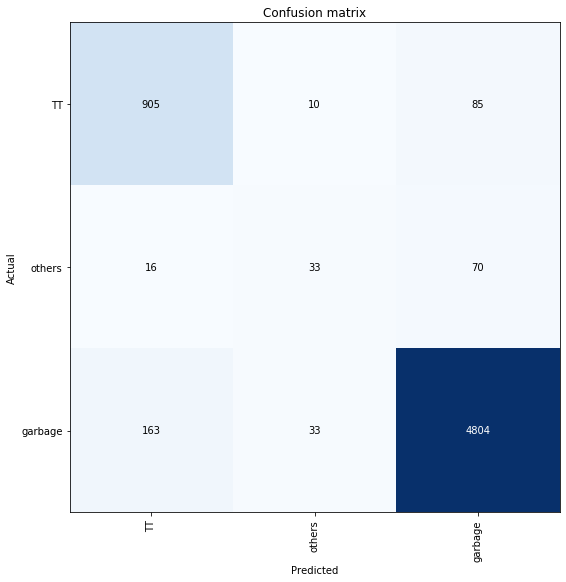

In [0]:
interp.plot_confusion_matrix(figsize=(8,8))

In [0]:
import glob

image_list = glob.glob('k9/valid/*/*')

C0 = 0
Pred_C0=0
C1=0
Pred_C1=0
C2=0
Pred_C2=0

for each in image_list:
    img = open_image(each)
    each = each.split('/')
    bc_class = each[2]
    pred_class, pred_idx, outputs = learn.predict(img)
    pred_class = str(pred_class)
         
    if bc_class == 'TT':
        C0 += 1
        if pred_class == 'TT':
            Pred_C0 += 1
    elif bc_class == 'others':
        C1 += 1
        if pred_class == 'others':
            Pred_C1 += 1
    elif bc_class == 'garbage':
        C2 += 1
        if pred_class == 'garbage':
            Pred_C2 += 1
            
    
print('TT classification: ' + str(Pred_C0) + '/' + str(C0))
print('others classification: ' + str(Pred_C1) + '/' + str(C1))
print('garbage classification: ' + str(Pred_C2) + '/' + str(C2) )

TT classification: 920/1000
others classification: 60/119
garbage classification: 4763/5000


In [0]:
# Validation score: 94.28%

In [0]:
##############Testing################### (not done)

In [0]:
# path_images = Path('cnrs')
data = ImageDataBunch.from_folder(path=path_images, train='train', valid='test', bs=bs, classes=['TT','others','garbage']) 
data.normalize()

ImageDataBunch;

Train: LabelList (26600 items)
x: ImageList
Image (3, 31, 248),Image (3, 31, 248),Image (3, 31, 248),Image (3, 31, 248),Image (3, 31, 248)
y: CategoryList
TT,TT,TT,TT,TT
Path: 10nov;

Valid: LabelList (8096 items)
x: ImageList
Image (3, 31, 248),Image (3, 31, 248),Image (3, 31, 248),Image (3, 31, 248),Image (3, 31, 248)
y: CategoryList
garbage,garbage,garbage,garbage,garbage
Path: 10nov;

Test: None

In [0]:
learn = cnn_learner(data, models.resnet152, metrics=error_rate)

In [0]:
learn = learn.load('bcells-r152')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

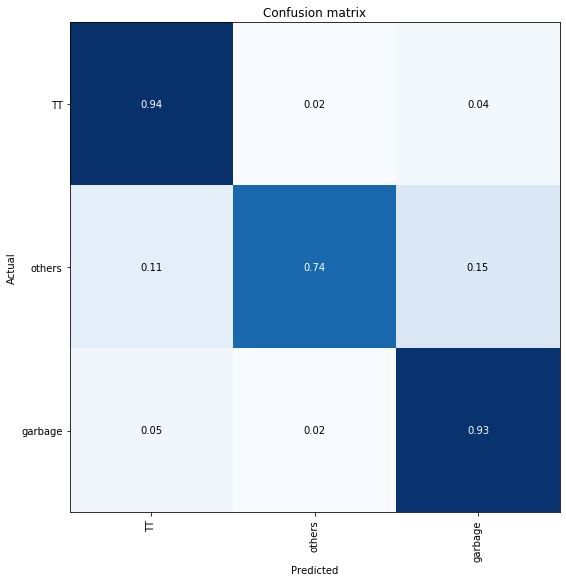

In [0]:
interp.plot_confusion_matrix(normalize=True, figsize=(8,8))

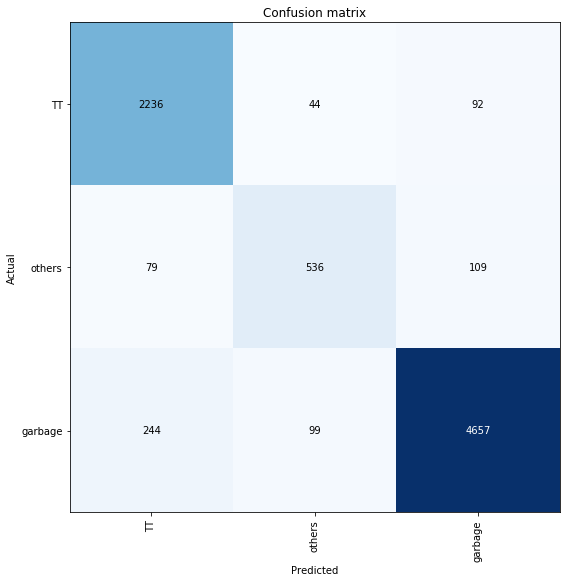

In [0]:
interp.plot_confusion_matrix(figsize=(8,8))

In [0]:
import glob

image_list = glob.glob('10nov/test/*/*')

C0 = 0
Pred_C0=0
C1=0
Pred_C1=0
C2=0
Pred_C2=0

for each in image_list:
    img = open_image(each)
    each = each.split('/')
    bc_class = each[2]
    pred_class, pred_idx, outputs = learn.predict(img)
    pred_class = str(pred_class)
         
    if bc_class == 'TT':
        C0 += 1
        if pred_class == 'TT':
            Pred_C0 += 1
    elif bc_class == 'others':
        C1 += 1
        if pred_class == 'others':
            Pred_C1 += 1
    elif bc_class == 'garbage':
        C2 += 1
        if pred_class == 'garbage':
            Pred_C2 += 1
            
    
print('TT classification: ' + str(Pred_C0) + '/' + str(C0))
print('others classification: ' + str(Pred_C1) + '/' + str(C1))
print('garbage classification: ' + str(Pred_C2) + '/' + str(C2) )

TT classification: 2236/2372
others classification: 536/724
garbage classification: 4657/5000
